Spark Session web UI: http://10.50.221.197:4040

 Summary stats for continous variables

Summary stats for FinishSqFt
+------------------+---------------+---------------+
|   avg(FinishSqFt)|min(FinishSqFt)|max(FinishSqFt)|
+------------------+---------------+---------------+
|1917.9353760066615|            0.0|     4531.12212|
+------------------+---------------+---------------+


Quartiles:
1432.0 1802.0 2356.0

Box plot:


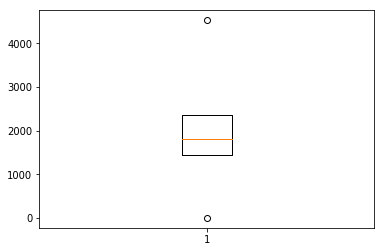


Summary stats for Long
+------------------+----------+----------+
|         avg(Long)| min(Long)| max(Long)|
+------------------+----------+----------+
|-93.81972812924046|-118.86924|-71.920446|
+------------------+----------+----------+


Quartiles:
-97.296323 -88.452152 -74.404121

Box plot:


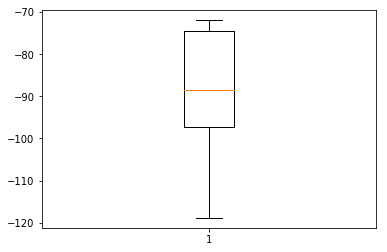


Summary stats for LotSqFt
+-----------------+------------+------------+
|     avg(LotSqFt)|min(LotSqFt)|max(LotSqFt)|
+-----------------+------------+------------+
|7914.639900654075|         0.0|  16978.7352|
+-----------------+------------+------------+


Quartiles:
6098.0 7348.0 9147.0

Box plot:


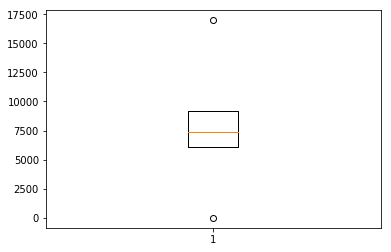


Summary stats for SalePrice
+----------------+--------------+--------------+
|  avg(SalePrice)|min(SalePrice)|max(SalePrice)|
+----------------+--------------+--------------+
|413051.373582945|       15000.0|     1257244.8|
+----------------+--------------+--------------+


Quartiles:
233000.0 407000.0 530000.0

Box plot:


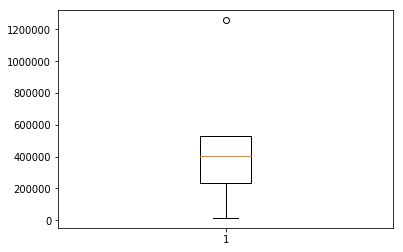


Summary stats for Lat
+-----------------+---------+--------+
|         avg(Lat)| min(Lat)|max(Lat)|
+-----------------+---------+--------+
|37.25230862729081|32.173163|42.66872|
+-----------------+---------+--------+


Quartiles:
33.680149 40.648315 41.142609

Box plot:


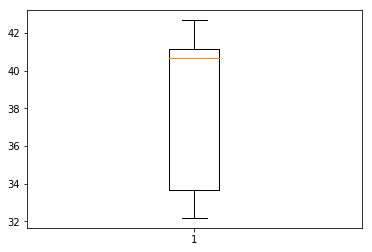


Summary stats for ID
+--------------------+-------+---------+
|             avg(ID)|min(ID)|  max(ID)|
+--------------------+-------+---------+
|3.7916460267633475E7|3242204|123031943|
+--------------------+-------+---------+


Quartiles:
25194651.0 33093532.0 55549468.0

Box plot:


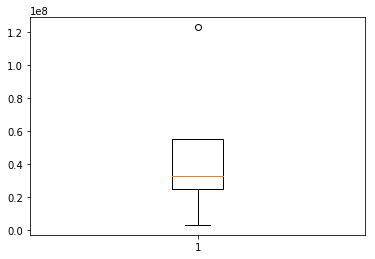


Summary stats for ListPrice
+-----------------+--------------+--------------+
|   avg(ListPrice)|min(ListPrice)|max(ListPrice)|
+-----------------+--------------+--------------+
|422063.9895114683|       15000.0|     1247607.9|
+-----------------+--------------+--------------+


Quartiles:
244000.0 365000.0 565000.0

Box plot:


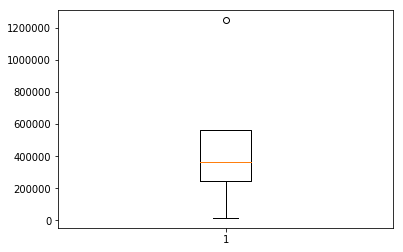


 Summary stats for categorical variables

Summary stats for City

Number of distinct categories: 1344

Bar Graph:


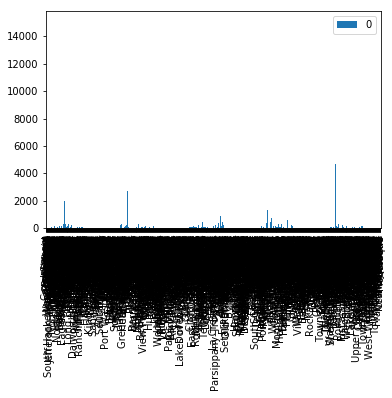


Summary stats for SaleYear

Number of distinct categories: 9

Bar Graph:


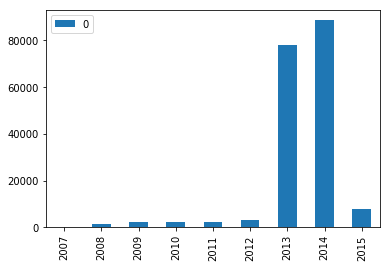


Summary stats for BuildDecade

Number of distinct categories: 32

Bar Graph:


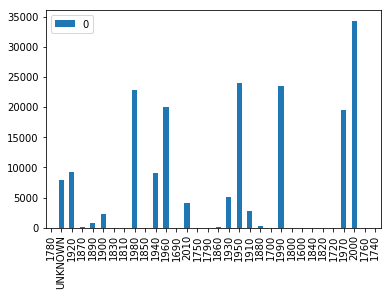


Summary stats for Bathroom

Number of distinct categories: 10

Bar Graph:


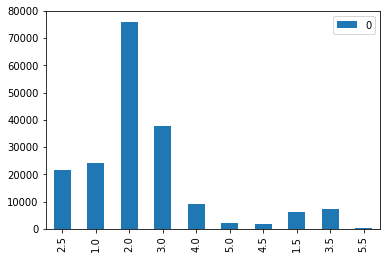


Summary stats for MajorRenov

Number of distinct categories: 118

Bar Graph:


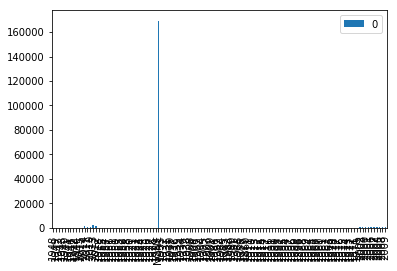


Summary stats for Bedroom

Number of distinct categories: 8

Bar Graph:


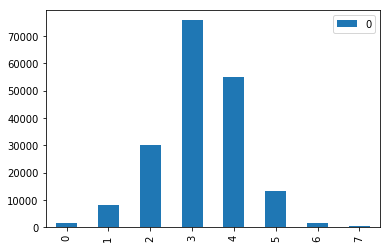


Summary stats for BuiltYear

Number of distinct categories: 205

Bar Graph:


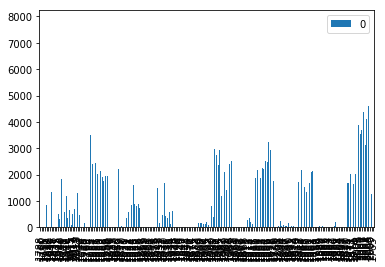


Summary stats for HighSchool

Number of distinct categories: 670

Bar Graph:


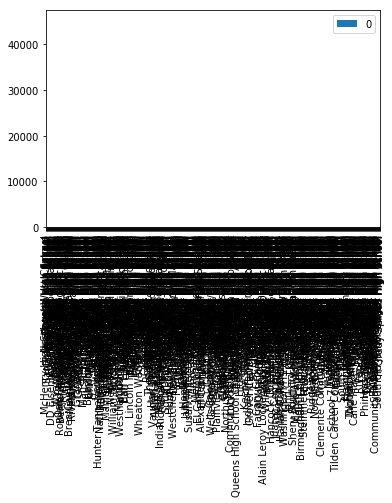


Summary stats for MSA

Number of distinct categories: 4

Bar Graph:


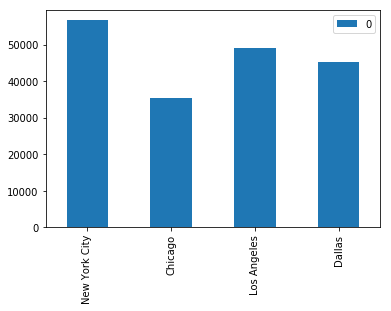

In [2]:
# Houses: Part A

import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import math
import os
import pandas
from collections import Counter


from pyspark.sql import SparkSession
from pyspark.sql import functions as PyF

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

##################################################################

def catSSFlatMap(row, key):
    return (row[key], 1)


##################################################################

# Setup

ID_KEY = "ID"
LAT_KEY = "Lat"
LONG_KEY = "Long"
LISTPRICE_KEY = "ListPrice"
SALEYEAR_KEY = "SaleYear"
BATHROOM_KEY = "Bathroom"
BEDROOM_KEY = "Bedroom"
BUILTYEAR_KEY = "BuiltYear"
BUILTDECADE_KEY = "BuildDecade"
MAJORRENOV_KEY = "MajorRenov"
FINISHSQFT_KEY = "FinishSqFt"
LOTSQFT_KEY = "LotSqFt"
MSA_KEY = "MSA"
CITY_KEY = "City"
HIGHSCHOOL_KEY = "HighSchool"
SALEPRICE_KEY = "SalePrice"

# NOTE: The union of these 3 sets contains all the indicies
GLOBAL_NUM_CATEGORICAL_KEY_SET = set([SALEYEAR_KEY, BATHROOM_KEY, BEDROOM_KEY,
                                        BUILTYEAR_KEY, BUILTDECADE_KEY])
GLOBAL_NUM_EMPIRICAL_KEY_SET = set([ID_KEY, LAT_KEY, LONG_KEY, LISTPRICE_KEY,
                                      FINISHSQFT_KEY, LOTSQFT_KEY, SALEPRICE_KEY])
GLOBAL_STR_CATEGORICAL_KEY_SET = set([MAJORRENOV_KEY, MSA_KEY, CITY_KEY, HIGHSCHOOL_KEY])


NUM_PARTITIONS = 28 * 20
SEED = 666 # For replicability

TRAIN_DATAPATH = '/project/cmsc25025/zillow/zillow-train.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder\
    .master('spark://' + ip + ':7077')\
    .appName('A6H_Spark')\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# Note: quote=empty string in order to deal with Crenshaw High School, which is notated distinctly but consistently
train_df = spark.read.csv(TRAIN_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)

# train_df.show()

print "\n Summary stats for continous variables"
for key in GLOBAL_NUM_EMPIRICAL_KEY_SET:
    print "\nSummary stats for " + str(key)
    stats = train_df.select([PyF.mean(key), PyF.min(key), PyF.max(key)])
    stats.show()
    
    tmp = stats.collect()
    mean_point = float(tmp[0][0])
    min_point = float(tmp[0][1])
    max_point = float(tmp[0][2])
    
    print "\nQuartiles:"
    quarter, median, three_quarters = train_df.approxQuantile(key, [.25, .5, .75], .1)
    print quarter, median, three_quarters
    
    print "\nBox plot:"
    
    my_data = np.array([min_point, quarter, median, three_quarters, max_point])
    
    plt.clf()
    plt.boxplot(my_data)
    plt.show()

print "\n Summary stats for categorical variables"

for key in GLOBAL_NUM_CATEGORICAL_KEY_SET | GLOBAL_STR_CATEGORICAL_KEY_SET:
    print "\nSummary stats for " + str(key)
    kv_list = train_df.rdd.map(lambda row: catSSFlatMap(row, key)).reduceByKey(lambda x,y: x + y).collect()
    
    kv_counter = Counter()
    for key, value in kv_list:
        kv_counter[key] = value
    
    print "\nNumber of distinct categories: " + str(len(kv_counter))

    print "\nBar Graph:"
    plt.clf()
    plot_df = pandas.DataFrame.from_dict(kv_counter, orient='index')
    plot_df.plot(kind='bar')
    plt.show()

spark.stop()


In [ ]:
# Comments:
# In some respects, the data appears to have been preproccesed. Namely, we note that all of the non-existent values
# for, say, BuildDecade, have been replaced with a consistent value, such as UNKNOWN. All of the prices appear to be rounded,
# and the text appears to be normalized (i.e, there are no equivalent string with different syntaxes, such as
# "Crenshaw High" and "CRENSHAW HIGH"). This fact reduces the need to try-except in our code. 
# However, it is evident that the data has not been run explicitly on this assignment. For example, for HighSchool,
# Chrenshaw Highschool features an extra ", which requires explicit handling, and the categorical numbers
# have not been replaced with a zero based index, which is done at a later step

In [1]:
# Houses: Part B - 1

import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import math
import os
import pandas
import time
from collections import Counter

from pyspark.sql import SparkSession
from pyspark.sql import functions as PyF

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.regression import LabeledPoint

##################################################################

def cleanAndLabelMap(row, categorical_dict):
    label = float(row[-1])
    data = np.array(row[1:-1])
    for index in range(len(data)):
        if index in categorical_dict: # converts all categorical variables to a 0-based index
            unique_mapping_dict = categorical_dict[index]
            
            current_val = data[index]
            data[index] = unique_mapping_dict[current_val]
        else:
            data[index] = float(data[index])

    return LabeledPoint(label, data)

##################################################################

# Setup
#############

LAT_INDEX = 0 # Continous, dropped
LONG_INDEX = 1 # Continous
LISTPRICE_INDEX = 2 # Continuous
SALEYEAR_INDEX = 3 # Categorical
BATHROOM_INDEX = 4 # Categorical
BEDROOM_INDEX = 5 # Categorical
BUILTYEAR_INDEX = 6 # Categorical
BUILTDECADE_INDEX = 7 # Categorical
MAJORRENOV_INDEX = 8 # Categorical
FINISHSQFT_INDEX = 9 # Continuous
LOTSQFT_INDEX = 10 # Continuous
MSA_INDEX = 11 # Categorical
CITY_INDEX = 12 # Categorical
HIGHSCHOOL_INDEX = 13 # Categorical
SALEPRICE_INDEX = 14 # Continuous, label variable

# NOTE: The union of these 3 sets contains all the indicies EXCEPT ID
# GLOBAL_NUM_EMPIRICAL_INDEX_SET = set([LAT_INDEX, LONG_INDEX, LISTPRICE_INDEX,
#                                       FINISHSQFT_INDEX, LOTSQFT_INDEX, SALEPRICE_INDEX])
GLOBAL_NUM_CATEGORICAL_INDEX_SET = set([SALEYEAR_INDEX, BATHROOM_INDEX, BEDROOM_INDEX,
                                        BUILTYEAR_INDEX, BUILTDECADE_INDEX, MAJORRENOV_INDEX,
                                        MSA_INDEX, CITY_INDEX, HIGHSCHOOL_INDEX])

##############

ID_KEY = "ID"
LAT_KEY = "Lat"
LONG_KEY = "Long"
LISTPRICE_KEY = "ListPrice"
SALEYEAR_KEY = "SaleYear"
BATHROOM_KEY = "Bathroom"
BEDROOM_KEY = "Bedroom"
BUILTYEAR_KEY = "BuiltYear"
BUILTDECADE_KEY = "BuildDecade"
MAJORRENOV_KEY = "MajorRenov"
FINISHSQFT_KEY = "FinishSqFt"
LOTSQFT_KEY = "LotSqFt"
MSA_KEY = "MSA"
CITY_KEY = "City"
HIGHSCHOOL_KEY = "HighSchool"
SALEPRICE_KEY = "SalePrice"

GLOBAL_KEY_TO_INDEX_DICT = {LAT_KEY:LAT_INDEX, LONG_KEY:LONG_INDEX, LISTPRICE_KEY:LISTPRICE_INDEX, SALEYEAR_KEY:SALEYEAR_INDEX,
                            BATHROOM_KEY:BATHROOM_INDEX, BEDROOM_KEY:BEDROOM_INDEX, BUILTYEAR_KEY:BUILTYEAR_INDEX,
                            BUILTDECADE_KEY:BUILTDECADE_INDEX, MAJORRENOV_KEY:MAJORRENOV_INDEX, FINISHSQFT_KEY:FINISHSQFT_INDEX,
                            LOTSQFT_KEY:LOTSQFT_INDEX, MSA_KEY:MSA_INDEX, CITY_KEY:CITY_INDEX, HIGHSCHOOL_KEY:HIGHSCHOOL_INDEX,
                            SALEPRICE_KEY:SALEPRICE_INDEX}

# NOTE: The union of these 3 sets contains all the indicies
GLOBAL_NUM_CATEGORICAL_KEY_SET = set([SALEYEAR_KEY, BATHROOM_KEY, BEDROOM_KEY,
                                        BUILTYEAR_KEY, BUILTDECADE_KEY])
# GLOBAL_NUM_EMPIRICAL_KEY_SET = set([ID_KEY, LAT_KEY, LONG_KEY, LISTPRICE_KEY,
#                                       FINISHSQFT_KEY, LOTSQFT_KEY, SALEPRICE_KEY])
GLOBAL_STR_CATEGORICAL_KEY_SET = set([MAJORRENOV_KEY, MSA_KEY, CITY_KEY, HIGHSCHOOL_KEY])

##############
NUM_PARTITIONS = 28 * 20
SEED = 666 # For replicability

TRAIN_DATAPATH = '/project/cmsc25025/zillow/zillow-train.csv'
TEST_DATAPATH = '/project/cmsc25025/zillow/zillow-test.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder\
    .master('spark://' + ip + ':7077')\
    .appName('A6H_Spark')\
    .config("spark.driver.maxResultSize", "24g")\
    .config("spark.executor.memory", "2g")\
    .config("spark.worker.cleanup.enabled", "true")\
    .config("spark.worker.cleanup.interval", "15")\
    .config("spark.worker.cleanup.appDataTtl", "15")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# Note: quote=empty string in order to deal with Crenshaw High School, which is notated distinctly but consistently
train_df = spark.read.csv(TRAIN_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)
test_df = spark.read.csv(TEST_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)

# Part B
##############

categorical_dict = {}
categorical_airity_dict = {}
for key in GLOBAL_NUM_CATEGORICAL_KEY_SET | GLOBAL_STR_CATEGORICAL_KEY_SET:
    unique_values_list = list(enumerate(train_df.select(key).distinct().rdd.map(lambda x: x[0]).collect()))
    unique_mapping_dict = {}
    for number, value in unique_values_list:
        unique_mapping_dict[str(value)] = number # no need to check for str. v. float b/c we are changing to 0-based index
    
    data_index = GLOBAL_KEY_TO_INDEX_DICT[key]
    categorical_dict[data_index] = unique_mapping_dict
    categorical_airity_dict[data_index] = len(unique_values_list)


# Load and parse the data file into an RDD of LabeledPoint.
labeled_rdd = train_df.rdd.map(lambda row: cleanAndLabelMap(row, categorical_dict))
# Split the data into training and test sets (30% held out for testing)
training_rdd, test_rdd = labeled_rdd.randomSplit([7, 3], SEED)
# Train a RandomForest model.
# Empty categoricalFeaturesInfo indicates all features are continuous.
# Note: Use larger numTrees in practice.
# Setting featureSubsetStrategy=’’auto’’ lets the algorithm choose.

# Feature experimenter

lowest_error = 1000000000000000
lowest_num_trees = None
lowest_depth = None
lowest_bins = None

num_trees_arr = range(4, 20 + 1, 2)
max_depth_arr = range(3, 10 + 1, 1)
max_bins_arr = range(1500, 5000, 100)

consec_error_count = 0

print "Entering testing loops: "
for num_trees in num_trees_arr:
    print "Setting Num Trees to " + str(num_trees)
    for max_depth in max_depth_arr:
        print "Setting Max Depth to " + str(max_depth)
        for max_bins in max_bins_arr:
            while True and consec_error_count < 30:
                try:
                    model = RandomForest.trainRegressor(training_rdd,
                                                            categoricalFeaturesInfo=categorical_airity_dict,
                                                            numTrees=num_trees, featureSubsetStrategy='auto',
                                                            impurity='variance', maxDepth=max_depth, maxBins=max_bins)


                    # Evaluate model on test instances and compute test error
                    predictions = model.predict(test_rdd.map(lambda x: x.features))
                    labelsAndPredictions = test_rdd.map(lambda lp: lp.label).zip(predictions)
                    testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(test_rdd.count())
                    print '\tObtained Test Mean Squared Error = ' + str(testMSE)

                    if testMSE < lowest_error:
                        lowest_error = testMSE
                        lowest_num_trees = num_trees
                        lowest_depth = max_depth
                        lowest_bins = max_bins

                        print "\t\t !!! Found new lowest MSE of " + str(lowest_error)
                        print "\t\t !!! Num trees = " + str(lowest_num_trees)
                        print "\t\t !!! Depth = " + str(lowest_depth)
                        print "\t\t !!! Bins = " + str(lowest_bins)

                    consec_error_count = 0
                    del(model)
                    del(predictions)
                    del(labelsAndPredictions)

                    time.sleep(5) # hopefully give the system more time to clean up some of the tmp files
                    
                    break # Throw out of while loop if successfully trained model
                    
                except:
                    print "ERROR: Py4JJavaError while training model"
                    print "Sleeping for 60 seconds to allow cleanup..."
                    consec_error_count += 1
                    print "Consec error count is " + str(consec_error_count)
                    time.sleep(60)
                    print "Retrying"
                    
                    if consec_error_count >= 30:
                        print "Consec error count exceeds threshold. Exiting"
                    
            
            
print 'Lowest MSE regression forest model:'
print "\tError: " + str(lowest_error)
print "\tNum trees: " + str(lowest_num_trees)
print "\tMax depth: " + str(lowest_depth)
print "\tNum bins: " + str(lowest_bins)

print "\nStopping"
spark.stop()


Spark Session web UI: http://10.50.221.198:4040
Entering testing loops: 
Setting Num Trees to 4
Setting Max Depth to 3
	Obtained Test Mean Squared Error = 9177794152.39
		 !!! Found new lowest MSE of 9177794152.39
		 !!! Num trees = 4
		 !!! Depth = 3
		 !!! Bins = 1500
	Obtained Test Mean Squared Error = 12002243599.9
	Obtained Test Mean Squared Error = 4882297122.58
		 !!! Found new lowest MSE of 4882297122.58
		 !!! Num trees = 4
		 !!! Depth = 3
		 !!! Bins = 1700
	Obtained Test Mean Squared Error = 8882455155.06
	Obtained Test Mean Squared Error = 6370008319.74
	Obtained Test Mean Squared Error = 8228381072.78
	Obtained Test Mean Squared Error = 12160999663.1
	Obtained Test Mean Squared Error = 10856846568.9
	Obtained Test Mean Squared Error = 10191341005.8
	Obtained Test Mean Squared Error = 8849738088.59
	Obtained Test Mean Squared Error = 6838467473.24
	Obtained Test Mean Squared Error = 6476098600.88
	Obtained Test Mean Squared Error = 8227529496.16
	Obtained Test Mean Squared

In [ ]:
# Comments: To solve for the best parameters, we brute-force a range of solutions as demonstrated in the code above
# Based off of the writeup, we would guess that a configuration with the highest depth and number of trees would be
# both the most expensive model to compute and the best model at predicting, as it would lower variance/bias and have
# good predictive power. # Generally, we find that is indeed the case, up to the point where the model cannot handle more
# trees/depth. Interestingly, as shown above, we generally find that a lower amount of bins lowers the MSE, all else being
# equal, so from this point forward, we set num_bins equal to 1500, approx. the largest number of categories a categorical
# variable possesses in our data.
# We do encounter periodic errors in which the node runs out of temporary storage, the spark config cleanup options
# and try-except loops exist to attempt to deal with it. Other times, we encounter heapspace errors, when
# we try to train a model that has too many trees/is too deep.
# More experimentation below

In [1]:
# Houses: Part B - 2

import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import math
import os
import pandas
import time
from collections import Counter

from pyspark.sql import SparkSession
from pyspark.sql import functions as PyF

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.regression import LabeledPoint

##################################################################

def cleanAndLabelMap(row, categorical_dict):
    label = float(row[-1])
    data = np.array(row[1:-1])
    for index in range(len(data)):
        if index in categorical_dict: # converts all categorical variables to a 0-based index
            unique_mapping_dict = categorical_dict[index]
            
            current_val = data[index]
            data[index] = unique_mapping_dict[current_val]
        else:
            data[index] = float(data[index])

    return LabeledPoint(label, data)

##################################################################

# Setup
#############

LAT_INDEX = 0 # Continous, dropped
LONG_INDEX = 1 # Continous
LISTPRICE_INDEX = 2 # Continuous
SALEYEAR_INDEX = 3 # Categorical
BATHROOM_INDEX = 4 # Categorical
BEDROOM_INDEX = 5 # Categorical
BUILTYEAR_INDEX = 6 # Categorical
BUILTDECADE_INDEX = 7 # Categorical
MAJORRENOV_INDEX = 8 # Categorical
FINISHSQFT_INDEX = 9 # Continuous
LOTSQFT_INDEX = 10 # Continuous
MSA_INDEX = 11 # Categorical
CITY_INDEX = 12 # Categorical
HIGHSCHOOL_INDEX = 13 # Categorical
SALEPRICE_INDEX = 14 # Continuous, label variable

# NOTE: The union of these 3 sets contains all the indicies EXCEPT ID
# GLOBAL_NUM_EMPIRICAL_INDEX_SET = set([LAT_INDEX, LONG_INDEX, LISTPRICE_INDEX,
#                                       FINISHSQFT_INDEX, LOTSQFT_INDEX, SALEPRICE_INDEX])
GLOBAL_NUM_CATEGORICAL_INDEX_SET = set([SALEYEAR_INDEX, BATHROOM_INDEX, BEDROOM_INDEX,
                                        BUILTYEAR_INDEX, BUILTDECADE_INDEX, MAJORRENOV_INDEX,
                                        MSA_INDEX, CITY_INDEX, HIGHSCHOOL_INDEX])

##############

ID_KEY = "ID"
LAT_KEY = "Lat"
LONG_KEY = "Long"
LISTPRICE_KEY = "ListPrice"
SALEYEAR_KEY = "SaleYear"
BATHROOM_KEY = "Bathroom"
BEDROOM_KEY = "Bedroom"
BUILTYEAR_KEY = "BuiltYear"
BUILTDECADE_KEY = "BuildDecade"
MAJORRENOV_KEY = "MajorRenov"
FINISHSQFT_KEY = "FinishSqFt"
LOTSQFT_KEY = "LotSqFt"
MSA_KEY = "MSA"
CITY_KEY = "City"
HIGHSCHOOL_KEY = "HighSchool"
SALEPRICE_KEY = "SalePrice"

GLOBAL_KEY_TO_INDEX_DICT = {LAT_KEY:LAT_INDEX, LONG_KEY:LONG_INDEX, LISTPRICE_KEY:LISTPRICE_INDEX, SALEYEAR_KEY:SALEYEAR_INDEX,
                            BATHROOM_KEY:BATHROOM_INDEX, BEDROOM_KEY:BEDROOM_INDEX, BUILTYEAR_KEY:BUILTYEAR_INDEX,
                            BUILTDECADE_KEY:BUILTDECADE_INDEX, MAJORRENOV_KEY:MAJORRENOV_INDEX, FINISHSQFT_KEY:FINISHSQFT_INDEX,
                            LOTSQFT_KEY:LOTSQFT_INDEX, MSA_KEY:MSA_INDEX, CITY_KEY:CITY_INDEX, HIGHSCHOOL_KEY:HIGHSCHOOL_INDEX,
                            SALEPRICE_KEY:SALEPRICE_INDEX}

# NOTE: The union of these 3 sets contains all the indicies
GLOBAL_NUM_CATEGORICAL_KEY_SET = set([SALEYEAR_KEY, BATHROOM_KEY, BEDROOM_KEY,
                                        BUILTYEAR_KEY, BUILTDECADE_KEY])
# GLOBAL_NUM_EMPIRICAL_KEY_SET = set([ID_KEY, LAT_KEY, LONG_KEY, LISTPRICE_KEY,
#                                       FINISHSQFT_KEY, LOTSQFT_KEY, SALEPRICE_KEY])
GLOBAL_STR_CATEGORICAL_KEY_SET = set([MAJORRENOV_KEY, MSA_KEY, CITY_KEY, HIGHSCHOOL_KEY])

##############
NUM_PARTITIONS = 28 * 20
SEED = 666 # For replicability

TRAIN_DATAPATH = '/project/cmsc25025/zillow/zillow-train.csv'
TEST_DATAPATH = '/project/cmsc25025/zillow/zillow-test.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder\
    .master('spark://' + ip + ':7077')\
    .appName('A6H_Spark')\
    .config("spark.driver.maxResultSize", "24g")\
    .config("spark.executor.memory", "2g")\
    .config("spark.worker.cleanup.enabled", "true")\
    .config("spark.worker.cleanup.interval", "15")\
    .config("spark.worker.cleanup.appDataTtl", "15")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# Note: quote=empty string in order to deal with Crenshaw High School, which is notated distinctly but consistently
train_df = spark.read.csv(TRAIN_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)
test_df = spark.read.csv(TEST_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)

# Part B
##############

categorical_dict = {}
categorical_airity_dict = {}
for key in GLOBAL_NUM_CATEGORICAL_KEY_SET | GLOBAL_STR_CATEGORICAL_KEY_SET:
    unique_values_list = list(enumerate(train_df.select(key).distinct().rdd.map(lambda x: x[0]).collect()))
    unique_mapping_dict = {}
    for number, value in unique_values_list:
        unique_mapping_dict[str(value)] = number # no need to check for str. v. float b/c we are changing to 0-based index
    
    data_index = GLOBAL_KEY_TO_INDEX_DICT[key]
    categorical_dict[data_index] = unique_mapping_dict
    categorical_airity_dict[data_index] = len(unique_values_list)


# Load and parse the data file into an RDD of LabeledPoint.
labeled_rdd = train_df.rdd.map(lambda row: cleanAndLabelMap(row, categorical_dict))
# Split the data into training and test sets (30% held out for testing)
training_rdd, test_rdd = labeled_rdd.randomSplit([7, 3], SEED)
# Train a RandomForest model.
# Empty categoricalFeaturesInfo indicates all features are continuous.
# Note: Use larger numTrees in practice.
# Setting featureSubsetStrategy=’’auto’’ lets the algorithm choose.

# Feature experimenter

lowest_error = 1000000000000000
lowest_num_trees = None
lowest_depth = None
lowest_bins = None

num_trees_arr = range(4, 20 + 1, 2)
max_depth_arr = range(3, 10 + 1, 1)
max_bins = 1500

consec_error_count = 0

print "Entering testing loops: "
for num_trees in num_trees_arr:
    print "Setting Num Trees to " + str(num_trees)
    for max_depth in max_depth_arr:
        print "Setting Max Depth to " + str(max_depth)
        while True and consec_error_count < 30:
            try:
                model = RandomForest.trainRegressor(training_rdd,
                                                        categoricalFeaturesInfo=categorical_airity_dict,
                                                        numTrees=num_trees, featureSubsetStrategy='auto',
                                                        impurity='variance', maxDepth=max_depth, maxBins=max_bins)


                # Evaluate model on test instances and compute test error
                predictions = model.predict(test_rdd.map(lambda x: x.features))
                labelsAndPredictions = test_rdd.map(lambda lp: lp.label).zip(predictions)
                testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(test_rdd.count())
                print '\tObtained Test Mean Squared Error = ' + str(testMSE)

                if testMSE < lowest_error:
                    lowest_error = testMSE
                    lowest_num_trees = num_trees
                    lowest_depth = max_depth
                    lowest_bins = max_bins

                    print "\t\t !!! Found new lowest MSE of " + str(lowest_error)
                    print "\t\t !!! Num trees = " + str(lowest_num_trees)
                    print "\t\t !!! Depth = " + str(lowest_depth)
                    print "\t\t !!! Bins = " + str(lowest_bins)

                consec_error_count = 0
                del(model)
                del(predictions)
                del(labelsAndPredictions)

                time.sleep(5) # hopefully give the system more time to clean up some of the tmp files
                
                break # Throw out of while loop if successfully trained model

            except:
                print "ERROR: Py4JJavaError while training model"
                print "Sleeping for 60 seconds to allow cleanup..."
                consec_error_count += 1
                print "Consec error count is " + str(consec_error_count)
                time.sleep(60)
                print "Retrying"

                if consec_error_count >= 30:
                    print "Consec error count exceeds threshold. Exiting"
            
            
print 'Lowest MSE regression forest model:'
print "\tError: " + str(lowest_error)
print "\tNum trees: " + str(lowest_num_trees)
print "\tMax depth: " + str(lowest_depth)
print "\tNum bins: " + str(lowest_bins)

print "\nStopping"
spark.stop()


Spark Session web UI: http://10.50.221.198:4040
Entering testing loops: 
Setting Num Trees to 4
Setting Max Depth to 3
	Obtained Test Mean Squared Error = 11242892271.9
		 !!! Found new lowest MSE of 11242892271.9
		 !!! Num trees = 4
		 !!! Depth = 3
		 !!! Bins = 1500
Setting Max Depth to 4
	Obtained Test Mean Squared Error = 4111827523.0
		 !!! Found new lowest MSE of 4111827523.0
		 !!! Num trees = 4
		 !!! Depth = 4
		 !!! Bins = 1500
Setting Max Depth to 5
	Obtained Test Mean Squared Error = 2567474617.54
		 !!! Found new lowest MSE of 2567474617.54
		 !!! Num trees = 4
		 !!! Depth = 5
		 !!! Bins = 1500
Setting Max Depth to 6
	Obtained Test Mean Squared Error = 1894757221.77
		 !!! Found new lowest MSE of 1894757221.77
		 !!! Num trees = 4
		 !!! Depth = 6
		 !!! Bins = 1500
Setting Max Depth to 7
	Obtained Test Mean Squared Error = 917437133.084
		 !!! Found new lowest MSE of 917437133.084
		 !!! Num trees = 4
		 !!! Depth = 7
		 !!! Bins = 1500
Setting Max Depth to 8
	Obtaine

In [ ]:
# Here, we see that, with the number of bins fixed, generally, we obtain lower MSE for configurations with
# higher depth vs. higher number of trees. Additional, ad-hoc results below. All configs run using the "auto" split
# features. We found that using options like "all" and "log2" did not produce better results, so we remained with auto
# In the end, we selected num trees = 6, depth = 8, bins = 1500, as it produced the lowest MSE, and did not
# non-deterministically crash like a model with num_trees > 6.

#Additional Results

# Setting Num Trees to 4
# Setting Max Depth to 8
# 	Obtained Test Mean Squared Error = 910292003.388
# 		 !!! Found new lowest MSE of 910292003.388
# 		 !!! Num trees = 4
# 		 !!! Depth = 8
# 		 !!! Bins = 1500
# Setting Num Trees to 6
# Setting Max Depth to 8
# 	Obtained Test Mean Squared Error = 724603861.116
# 		 !!! Found new lowest MSE of 724603861.116
# 		 !!! Num trees = 6
# 		 !!! Depth = 8
# 		 !!! Bins = 1500

# Entering testing loops: 
# Setting Num Trees to 12
# Setting Max Depth to 5
# 	Obtained Test Mean Squared Error = 1861056308.71
# 		 !!! Found new lowest MSE of 1861056308.71
# 		 !!! Num trees = 12
# 		 !!! Depth = 5
# 		 !!! Bins = 1500
# Lowest MSE regression forest model:
# 	Error: 1861056308.71
# 	Num trees: 12
# 	Max depth: 5
# 	Num bins: 1500

# Stopping

# Entering testing loops: 
# Setting Num Trees to 12
# Setting Max Depth to 6
# 	Obtained Test Mean Squared Error = 772873365.658
# 		 !!! Found new lowest MSE of 772873365.658
# 		 !!! Num trees = 12
# 		 !!! Depth = 6
# 		 !!! Bins = 1500
# Lowest MSE regression forest model:
# 	Error: 772873365.658
# 	Num trees: 12
# 	Max depth: 6
# 	Num bins: 1500

# Stopping

# Entering testing loops: 
# Setting Num Trees to 8
# Setting Max Depth to 8
# 	Obtained Test Mean Squared Error = 767980598.112
# 		 !!! Found new lowest MSE of 767980598.112
# 		 !!! Num trees = 8
# 		 !!! Depth = 8
# 		 !!! Bins = 1400
# Lowest MSE regression forest model:
# 	Error: 767980598.112
# 	Num trees: 8
# 	Max depth: 8
# 	Num bins: 1500

# Stopping

#Using log2 splits
# Spark Session web UI: http://10.50.221.198:4040
# 	Obtained Test Mean Squared Error = 1290198724.81
# 		 !!! Found new lowest MSE of 1290198724.81
# 		 !!! Num trees = 6
# 		 !!! Depth = 8
# 		 !!! Bins = 1500

In [14]:
# Houses: Part C

import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import math
import os
import pandas
import time
from collections import Counter

from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as PyF
from pyspark.mllib.linalg import Vectors

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.regression import LabeledPoint

##################################################################

def cleanAndLabelMap(row, categorical_dict):
    label = float(row[-1])
    data = np.array(row[1:-1])
    for index in range(len(data)):
        if index in categorical_dict: # converts all categorical variables to a 0-based index
            unique_mapping_dict = categorical_dict[index]
            
            current_val = data[index]
            data[index] = unique_mapping_dict[current_val]
        else:
            data[index] = float(data[index])
    return LabeledPoint(label, data)

def cleanMap(row, categorical_dict):
    data = np.array(row[1:-1])
    for index in range(len(data)):
        if index in categorical_dict: # converts all categorical variables to a 0-based index
            unique_mapping_dict = categorical_dict[index]
            
            current_val = data[index]
            data[index] = unique_mapping_dict[current_val]
        else:
            data[index] = float(data[index])
            
    return Vectors.dense(data)

def predictMap(row, schema):
    base = Row(*schema)
    og_data = list(row[0])[:-1]
    og_data.append(row[1])
    return base(*og_data)
##################################################################

# Setup
#############

LAT_INDEX = 0 # Continous, dropped
LONG_INDEX = 1 # Continous
LISTPRICE_INDEX = 2 # Continuous
SALEYEAR_INDEX = 3 # Categorical
BATHROOM_INDEX = 4 # Categorical
BEDROOM_INDEX = 5 # Categorical
BUILTYEAR_INDEX = 6 # Categorical
BUILTDECADE_INDEX = 7 # Categorical
MAJORRENOV_INDEX = 8 # Categorical
FINISHSQFT_INDEX = 9 # Continuous
LOTSQFT_INDEX = 10 # Continuous
MSA_INDEX = 11 # Categorical
CITY_INDEX = 12 # Categorical
HIGHSCHOOL_INDEX = 13 # Categorical
SALEPRICE_INDEX = 14 # Continuous, label variable

# NOTE: The union of these 3 sets contains all the indicies EXCEPT ID
# GLOBAL_NUM_EMPIRICAL_INDEX_SET = set([LAT_INDEX, LONG_INDEX, LISTPRICE_INDEX,
#                                       FINISHSQFT_INDEX, LOTSQFT_INDEX, SALEPRICE_INDEX])
GLOBAL_NUM_CATEGORICAL_INDEX_SET = set([SALEYEAR_INDEX, BATHROOM_INDEX, BEDROOM_INDEX,
                                        BUILTYEAR_INDEX, BUILTDECADE_INDEX, MAJORRENOV_INDEX,
                                        MSA_INDEX, CITY_INDEX, HIGHSCHOOL_INDEX])

##############

ID_KEY = "ID"
LAT_KEY = "Lat"
LONG_KEY = "Long"
LISTPRICE_KEY = "ListPrice"
SALEYEAR_KEY = "SaleYear"
BATHROOM_KEY = "Bathroom"
BEDROOM_KEY = "Bedroom"
BUILTYEAR_KEY = "BuiltYear"
BUILTDECADE_KEY = "BuildDecade"
MAJORRENOV_KEY = "MajorRenov"
FINISHSQFT_KEY = "FinishSqFt"
LOTSQFT_KEY = "LotSqFt"
MSA_KEY = "MSA"
CITY_KEY = "City"
HIGHSCHOOL_KEY = "HighSchool"
SALEPRICE_KEY = "SalePrice"

GLOBAL_KEY_TO_INDEX_DICT = {LAT_KEY:LAT_INDEX, LONG_KEY:LONG_INDEX, LISTPRICE_KEY:LISTPRICE_INDEX, SALEYEAR_KEY:SALEYEAR_INDEX,
                            BATHROOM_KEY:BATHROOM_INDEX, BEDROOM_KEY:BEDROOM_INDEX, BUILTYEAR_KEY:BUILTYEAR_INDEX,
                            BUILTDECADE_KEY:BUILTDECADE_INDEX, MAJORRENOV_KEY:MAJORRENOV_INDEX, FINISHSQFT_KEY:FINISHSQFT_INDEX,
                            LOTSQFT_KEY:LOTSQFT_INDEX, MSA_KEY:MSA_INDEX, CITY_KEY:CITY_INDEX, HIGHSCHOOL_KEY:HIGHSCHOOL_INDEX,
                            SALEPRICE_KEY:SALEPRICE_INDEX}

# NOTE: The union of these 3 sets contains all the indicies
GLOBAL_NUM_CATEGORICAL_KEY_SET = set([SALEYEAR_KEY, BATHROOM_KEY, BEDROOM_KEY,
                                        BUILTYEAR_KEY, BUILTDECADE_KEY])
GLOBAL_STR_CATEGORICAL_KEY_SET = set([MAJORRENOV_KEY, MSA_KEY, CITY_KEY, HIGHSCHOOL_KEY])

##############
NUM_PARTITIONS = 28 * 20
SEED = 666 # For replicability

TRAIN_DATAPATH = '/project/cmsc25025/zillow/zillow-train.csv'
TEST_DATAPATH = '/project/cmsc25025/zillow/zillow-test.csv'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder\
    .master('spark://' + ip + ':7077')\
    .appName('A6H_Spark')\
    .config("spark.driver.maxResultSize", "32g")\
    .config("spark.executor.memory", "3g")\
    .config("spark.worker.cleanup.enabled", "true")\
    .config("spark.worker.cleanup.interval", "15")\
    .config("spark.worker.cleanup.appDataTtl", "15")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# Note: quote=empty string in order to deal with Crenshaw High School, which is notated distinctly but consistently
train_df = spark.read.csv(TRAIN_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)
test_df = spark.read.csv(TEST_DATAPATH, header=True, inferSchema=True, quote="").repartition(NUM_PARTITIONS)

# Setup
##############

categorical_dict = {}
categorical_airity_dict = {}
for key in GLOBAL_NUM_CATEGORICAL_KEY_SET | GLOBAL_STR_CATEGORICAL_KEY_SET:
    unique_values_list = list(enumerate(list(\
                              set(train_df.select(key).distinct().rdd.map(lambda x: x[0]).collect()) |\
                              set(test_df.select(key).distinct().rdd.map(lambda x: x[0]).collect())\
                             )))
    # print unique_values_list
    unique_mapping_dict = {}
    for number, value in unique_values_list:
        unique_mapping_dict[str(value)] = number # no need to check for str. v. float b/c we are changing to 0-based index
    
    data_index = GLOBAL_KEY_TO_INDEX_DICT[key]
    categorical_dict[data_index] = unique_mapping_dict
    categorical_airity_dict[data_index] = len(unique_values_list)


# Load and parse the data file into an RDD of LabeledPoint.
labeled_rdd = train_df.rdd.map(lambda row: cleanAndLabelMap(row, categorical_dict))
test_rdd = test_df.rdd.map(lambda row: cleanMap(row, categorical_dict))
# Split the data into training and test sets (30% held out for testing)

num_trees = 8
max_depth = 8
max_bins = 1500

training_rdd, _ = labeled_rdd.randomSplit([65, 35], SEED)
print "training model..."
model = RandomForest.trainRegressor(training_rdd,
                                    categoricalFeaturesInfo=categorical_airity_dict,
                                    numTrees=num_trees, featureSubsetStrategy='auto',
                                    impurity='variance', maxDepth=max_depth, maxBins=max_bins)
print "trained model"

print "generating prediction..."
# Evaluate model on test instances and compute test error
predictions = model.predict(test_rdd)
og_data_and_predictions = test_df.rdd.zip(predictions)
print og_data_and_predictions.take(1)
header = ["ID", "Lat", "Long", "ListPrice", "SaleYear", "Bathroom", "Bedroom", "BuiltYear", "BuildDecade",
          "MajorRenov", "FinishSqFt", "LotSqFt", "MSA", "City", "HighSchool", "SalePrice"]
predicted_rdd = og_data_and_predictions.map(lambda row: predictMap(row, header))

print "generated predictions"
print predicted_rdd.first()
predicted_df = spark.createDataFrame(predicted_rdd, header)
print predicted_df.show()

print "writing out csv..."
outpath = "assn6_prob3_predict.csv"
predicted_df.write.csv(outpath)
print "successful"
            

print "\nStopping"
spark.stop()


Spark Session web UI: http://10.50.221.198:4040
training model...
trained model
generating prediction...
[(Row(ID=3372676, Lat=42.074827, Long=-87.724608, ListPrice=699000.0, SaleYear=2013, Bathroom=1.5, Bedroom=3, BuiltYear=u'1953', BuildDecade=u'1950', MajorRenov=u'NONE', FinishSqFt=0.0, LotSqFt=6600.0, MSA=u'Chicago', City=u'Wilmette', HighSchool=u'New Trier Township H S Winnetka', SalePrice=u'*'), 655461.2041309535)]
generated predictions
Row(ID=3372676, Lat=42.074827, Long=-87.724608, ListPrice=699000.0, SaleYear=2013, Bathroom=1.5, Bedroom=3, BuiltYear=u'1953', BuildDecade=u'1950', MajorRenov=u'NONE', FinishSqFt=0.0, LotSqFt=6600.0, MSA=u'Chicago', City=u'Wilmette', HighSchool=u'New Trier Township H S Winnetka', SalePrice=655461.2041309535)
+--------+---------+-----------+---------+--------+--------+-------+---------+-----------+----------+----------+-----------+-------------+-----------------+--------------------+------------------+
|      ID|      Lat|       Long|ListPrice|Sale